In [1]:
import pickle

train_size=500

k_a_model = pickle.load(open(f"data/ph/q4/ph_k_a_model_[size={train_size}].pkl", "rb"))
k_e_model = pickle.load(open(f"data/ph/q4/ph_k_e_model_[size={train_size}].pkl", "rb"))
cl_model = pickle.load(open(f"data/ph/q4/ph_cl_model_[size={train_size}].pkl", "rb"))
sigma_model = pickle.load(open(f"data/ph/q4/ph_sigma_model_[size={train_size}].pkl", "rb"))

In [2]:
k_a_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    K_a   R-squared:                       0.458
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     45.97
Date:                Wed, 27 Dec 2023   Prob (F-statistic):           1.01e-59
Time:                        22:44:11   Log-Likelihood:                -199.97
No. Observations:                 500   AIC:                             419.9
Df Residuals:                     490   BIC:                             462.1
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2382      0.026     48.077      0.000       1.188       1.289
x_[t=0.25]     0.1458      0.097      1.500      0.134      -0.045       0.337
x_[t=0.5]      0.2362      0.104      2.281      0.023       0.033       0.440
x_[t=1]       -0.0203      0.069     -0.292      0.770      -0.157       0.116
x_[t=2]       -0.1584      0.051     -3.096      0.002      -0.259      -0.058
x_[t=3.5]     -0.1065      0.046     -2.317      0.021      -0.197      -0.016
x_[t=5]        0.0438      0.043      1.030      0.303      -0.040       0.127
x_[t=7]        0.0764      0.042      1.831      0.068      -0.006       0.158
x_[t=9]        0.0068      0.038      0.177      0.860      -0.068       0.082
x_[t=12]      -0.0081      0.027     -0.302      0.762      -0.060       0.044
==============================================================================
Omnibus:                       42.034   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              100.855
Skew:                           0.438   Prob(JB):                     1.26e-22
Kurtosis:                       5.018   Cond. No.                         157.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [3]:
k_a_model.params

const         1.238178
x_[t=0.25]    0.145794
x_[t=0.5]     0.236249
x_[t=1]      -0.020287
x_[t=2]      -0.158406
x_[t=3.5]    -0.106451
x_[t=5]       0.043843
x_[t=7]       0.076378
x_[t=9]       0.006751
x_[t=12]     -0.008065
dtype: float64

/var/folders/rs/c9bqjyq95q59ngc5v1t0gz_00000gn/T/ipykernel_4797/721907401.py:16: RuntimeWarning: invalid value encountered in log
  plt.plot(x, d2.pdf(np.log((x-mu)/sigma)))
/var/folders/rs/c9bqjyq95q59ngc5v1t0gz_00000gn/T/ipykernel_4797/721907401.py:11: RuntimeWarning: divide by zero encountered in log
  d3_pdf = lambda x: (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
/var/folders/rs/c9bqjyq95q59ngc5v1t0gz_00000gn/T/ipykernel_4797/721907401.py:11: RuntimeWarning: invalid value encountered in divide
  d3_pdf = lambda x: (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))


(1.246076730587381,
 1.1502737988572274,
 1.166871186668625,
 0.5190487278465993,
 1.4918246976412703,
 0.4858600903135478)

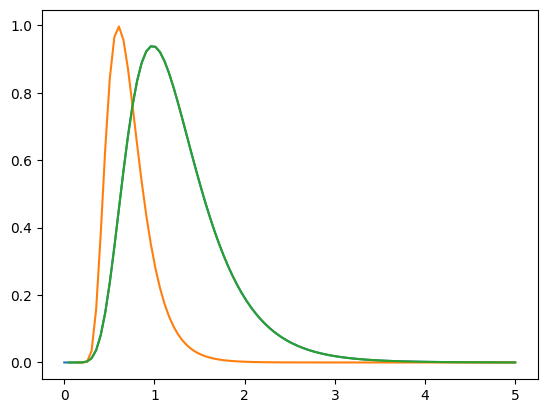

In [7]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np

mu = 0.14
sigma = 0.4

d1 = stats.lognorm(s=sigma, scale=np.exp(mu))
d2 = stats.norm(loc=mu, scale=sigma)
d3 = np.random.lognormal(mean=mu, sigma=sigma, size=100)
d3_pdf = lambda x: (np.exp(-(np.log(x) - mu)**2 / (2 * sigma**2))
       / (x * sigma * np.sqrt(2 * np.pi)))

x = np.linspace(0, 5, 100)
plt.plot(x, d1.pdf(x))
plt.plot(x, d2.pdf(np.log((x-mu)/sigma)))
plt.plot(x, d3_pdf(x))
# plt.legend(['lognorm', 'norm', 'lognorm (numpy)'])
d1.mean(), np.exp(d2.mean()), d3.mean(), d1.std(), np.exp(d2.std()), d3.std()

In [3]:
np.log(0.07)

-2.659260036932778

In [15]:
import numpy as np

sample_0_25 = np.load("data/ph/q5/rw_lognorm/ph_rw_[tol=0.25]_[N=10000].npy")
sample_0_7 = np.load("data/ph/q5/rw_lognorm/ph_rw_[tol=0.7]_[N=10000].npy")
sample_1 = np.load("data/ph/q5/rw_lognorm/ph_rw_[tol=1]_[N=10000].npy")

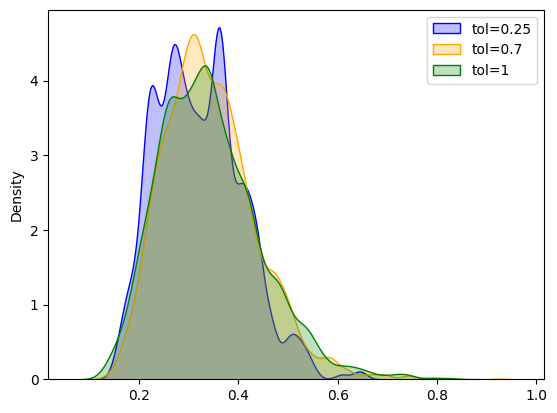

In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# KDE for X1 (marginalizing over X2, X3, X4)
kde_X1 = sns.kdeplot(sample_0_25[:, 3], fill=True, color='blue', label='tol=0.25')
kde_X2 = sns.kdeplot(sample_0_7[:, 3], fill=True, color='orange', label='tol=0.7')
kde_X3 = sns.kdeplot(sample_1[:, 3], fill=True, color='green', label='tol=1')

plt.legend()
plt.show()
